# SECCIÓN 1: Instalación de Dependencias y Descarga del Dataset desde Roboflow



In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="VBAQRpw9273AXkedUZfd")
project = rf.workspace("coralreef").project("coral-reef-bleach-detection")
version = project.version(2)
dataset = version.download("multiclass")

print(f"Dataset path: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...
Dataset path: /content/Coral-Reef-Bleach-Detection-2


# SECCIÓN 2: Importar librerías y Configurar rutas y clases

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

In [ ]:
base_path = '/content/Coral-Reef-Bleach-Detection-2'
classes_df = pd.read_csv(os.path.join(base_path, "train", "_classes.csv"))

# Obtener nombre de clase por imagen
classes_df.columns = [col.strip() for col in classes_df.columns]
label_cols = [col for col in classes_df.columns if col.lower() != "filename"]
classes_df["class"] = classes_df[label_cols].idxmax(axis=1).str.strip()
class_names = sorted(classes_df["class"].unique().tolist())
class_to_index = {cls: i for i, cls in enumerate(class_names)}

print("Clases:", class_names)

Clases: ['Bleached', 'Healthy']


# Sección 3: Cargar Imágenes y subconjuntos

---



In [ ]:
def cargar_imagenes_desde_directorio(directorio, classes_df):
    X, y = [], []
    for archivo in os.listdir(directorio):
        if archivo.endswith(".jpg") or archivo.endswith(".png"):
            ruta_img = os.path.join(directorio, archivo)
            fila = classes_df[classes_df["filename"] == archivo]
            if fila.empty:
                continue
            clase = fila.iloc[0]["class"]
            img = Image.open(ruta_img).convert("L").resize((56, 56))
            img_array = np.array(img).astype("float32") / 255.0
            X.append(img_array.flatten())
            y.append(class_to_index[clase])
    return np.array(X), np.array(y)

In [ ]:
# Cargar datos de entrenamiento
X_train, y_train = cargar_imagenes_desde_directorio(os.path.join(base_path, "train"), classes_df)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Cargar y preparar CSV del conjunto de prueba
classes_df_test = pd.read_csv(os.path.join(base_path, "test", "_classes.csv"))
classes_df_test.columns = [col.strip() for col in classes_df_test.columns]
label_cols_test = [col for col in classes_df_test.columns if col.lower() != "filename"]
classes_df_test["class"] = classes_df_test[label_cols_test].idxmax(axis=1).str.strip()

# Cargar imágenes del conjunto de prueba
X_test, y_test = cargar_imagenes_desde_directorio(os.path.join(base_path, "test"), classes_df_test)

# Verificar tamaños
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Valid: {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")


Train: (8035, 3136), (8035,)
Valid: (2009, 3136), (2009,)
Test:  (263, 3136), (263,)


#Sección 4: Preparar etiquetas categóricas

In [ ]:
y_train_cat = to_categorical(y_train, num_classes=len(class_names))
y_val_cat   = to_categorical(y_val,   num_classes=len(class_names))
y_test_cat  = to_categorical(y_test,  num_classes=len(class_names)) if len(y_test) > 0 else None

# Sección 5: MLP con optimizador Adam

## Sección 5.1: Definición y compilación del modelo MLP

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')  # salida multiclase
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 836,226 (3.19 MB)

 Trainable params: 836,226 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

## Sección 5.2: Entrenamiento del modelo sobre los datos de validación

In [ ]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5360 - loss: 0.7765 - val_accuracy: 0.6431 - val_loss: 0.6374
Epoch 2/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6019 - loss: 0.6599 - val_accuracy: 0.6814 - val_loss: 0.6227
Epoch 3/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6348 - loss: 0.6288 - val_accuracy: 0.6765 - val_loss: 0.6161
Epoch 4/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6471 - loss: 0.6179 - val_accuracy: 0.6814 - val_loss: 0.6134
Epoch 5/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6594 - loss: 0.6040 - val_accuracy: 0.6779 - val_loss: 0.6013
Epoch 6/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6746 - loss: 0.5946 - val_accuracy: 0.6929 - val_loss: 0.5814
Epoch 7/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6722 - loss: 0.5903 - val_accuracy: 0.7058 - val_loss: 0.5712
Epoch 8/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6516 - loss: 0.6046 - val_accu

## Sección 5.3: Visualización de curvas de pérdida y precisión

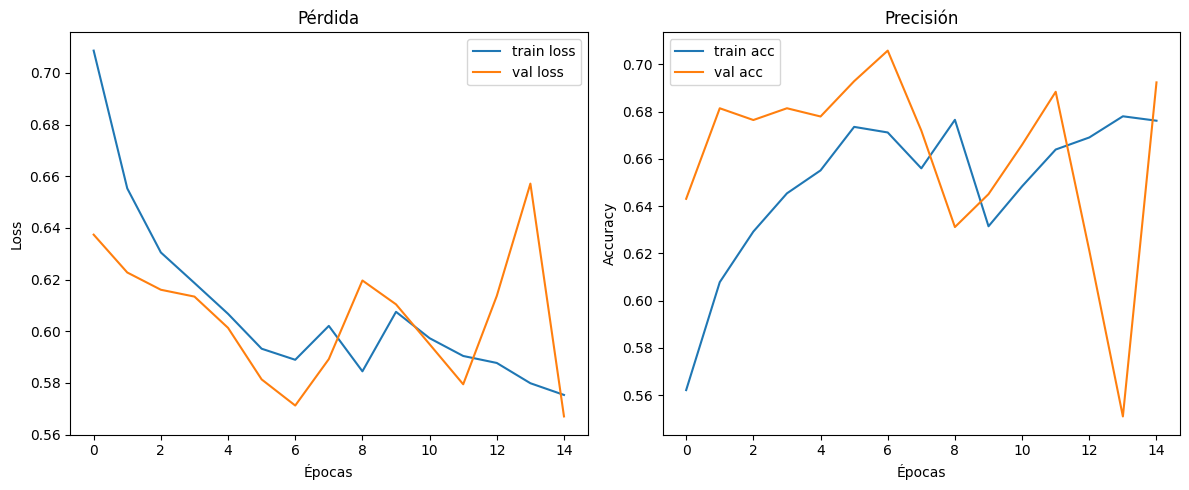

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Sección 5.4: Evaluación del modelo en el conjunto de prueba

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

    Bleached       0.78      0.55      0.65       141
     Healthy       0.61      0.82      0.70       122

    accuracy                           0.68       263
   macro avg       0.70      0.69      0.67       263
weighted avg       0.70      0.68      0.67       263



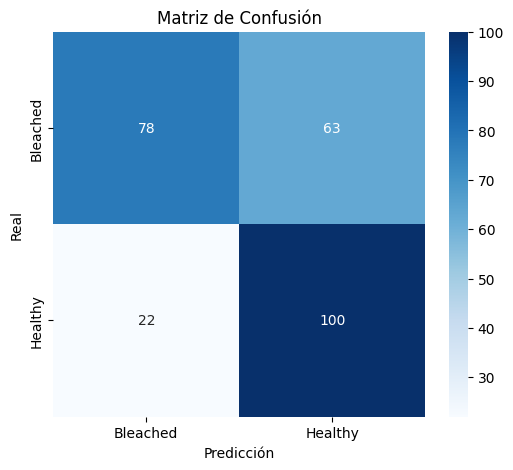

In [ ]:
if X_test.shape[0] > 0:
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()
else:
    print("El conjunto de test está vacío. No se puede evaluar el modelo.")

# Sección 6: MLP con optimizador SGD

## Sección 6.1 Definición y compilación del modelo MLP

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')  # salida multiclase
])

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 836,226 (3.19 MB)

 Trainable params: 836,226 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

## Sección 6.2 Entrenamiento del modelo sobre los datos de validación

In [ ]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5575 - loss: 0.6812 - val_accuracy: 0.6327 - val_loss: 0.6407
Epoch 2/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6355 - loss: 0.6467 - val_accuracy: 0.6655 - val_loss: 0.6235
Epoch 3/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6671 - loss: 0.6182 - val_accuracy: 0.6491 - val_loss: 0.6233
Epoch 4/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6718 - loss: 0.6066 - val_accuracy: 0.4749 - val_loss: 0.7913
Epoch 5/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6924 - loss: 0.5899 - val_accuracy: 0.6765 - val_loss: 0.5941
Epoch 6/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6892 - loss: 0.5862 - val_accuracy: 0.6610 - val_loss: 0.6176
Epoch 7/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7104 - loss: 0.5687 - val_accuracy: 0.6889 - val_loss: 0.5819
Epoch 8/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7015 - loss: 0.5665 - val_accuracy:

## Sección 6.3 Visualización de curvas de pérdida y precisión

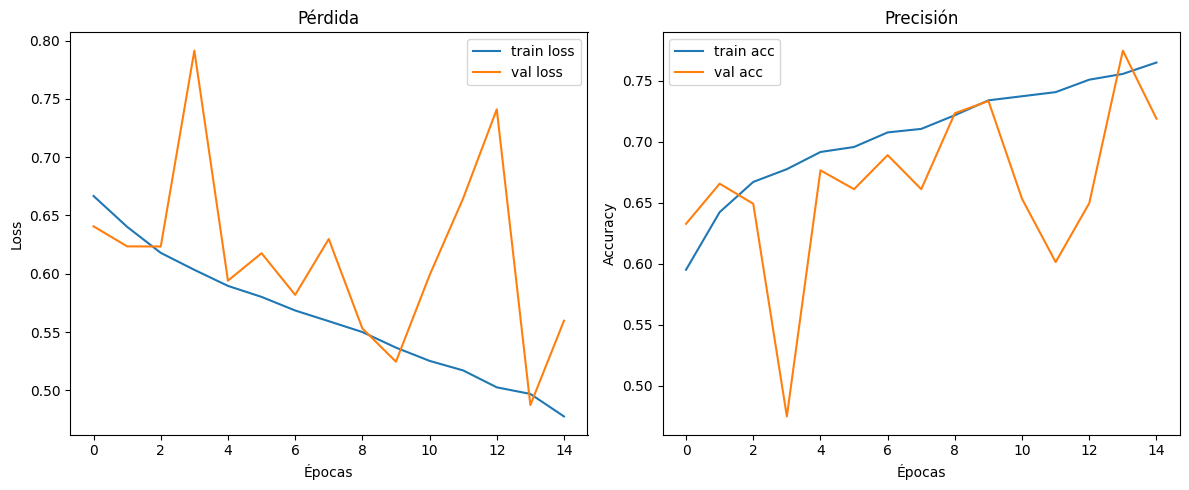

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Sección 6.4 Evaluación del modelo en el conjunto de prueba

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

    Bleached       0.69      0.94      0.80       141
     Healthy       0.88      0.52      0.65       122

    accuracy                           0.74       263
   macro avg       0.78      0.73      0.72       263
weighted avg       0.78      0.74      0.73       263



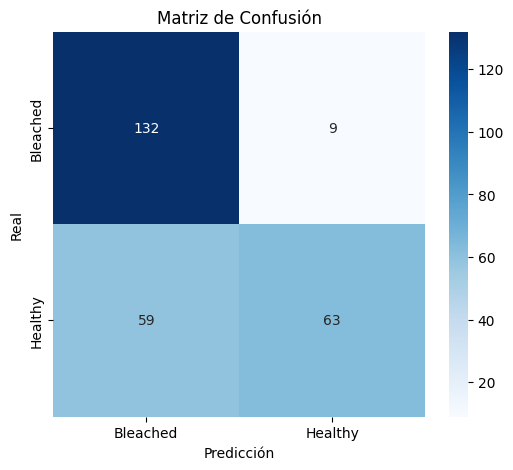

In [ ]:
if X_test.shape[0] > 0:
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()
else:
    print("El conjunto de test está vacío. No se puede evaluar el modelo.")

# Sección 7: MLP con optimizador Lion

## Sección 7.1 Definición y compilación del modelo MLP


In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')  # salida multiclase
])

model.compile(optimizer='Lion',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 836,226 (3.19 MB)

 Trainable params: 836,226 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

## Sección 7.2 Entrenamiento del modelo sobre los datos de validación

In [ ]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5647 - loss: 0.7628 - val_accuracy: 0.6849 - val_loss: 0.6360
Epoch 2/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6334 - loss: 0.6435 - val_accuracy: 0.5600 - val_loss: 0.6801
Epoch 3/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6561 - loss: 0.6217 - val_accuracy: 0.6829 - val_loss: 0.5960
Epoch 4/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6627 - loss: 0.6029 - val_accuracy: 0.5610 - val_loss: 0.6807
Epoch 5/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6733 - loss: 0.6012 - val_accuracy: 0.6874 - val_loss: 0.5770
Epoch 6/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.6805 - loss: 0.5921 - val_accuracy: 0.6416 - val_loss: 0.8038
Epoch 7/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6929 - loss: 0.5746 - val_accuracy: 0.6556 - val_loss: 1.1092
Epoch 8/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6929 - loss: 0.5711 - val_accu

## Sección 7.3 Visualización de curvas de pérdida y precisión

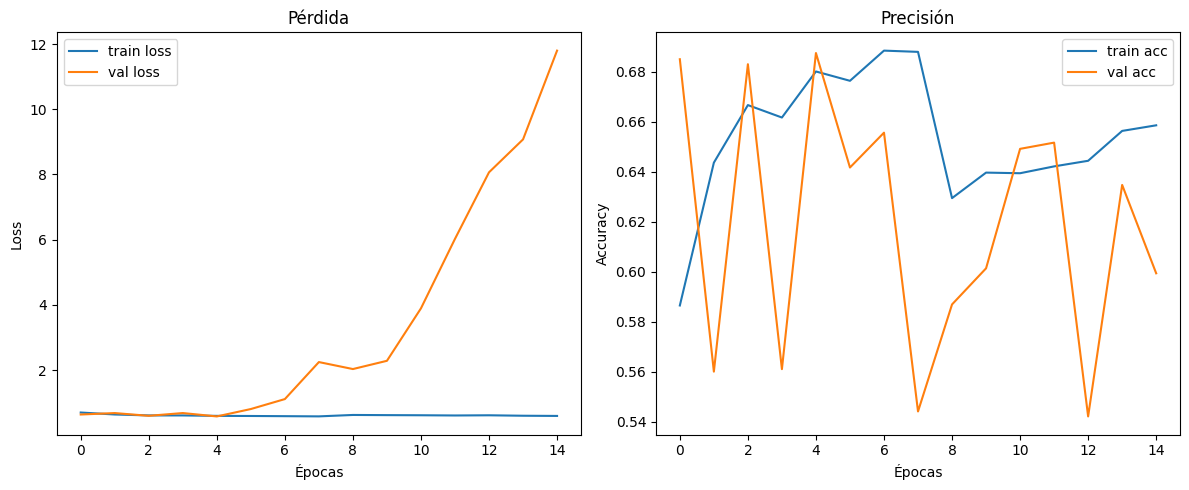

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Sección 7.4 Evaluación del modelo en el conjunto de prueba

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

    Bleached       0.83      0.42      0.56       141
     Healthy       0.57      0.90      0.70       122

    accuracy                           0.64       263
   macro avg       0.70      0.66      0.63       263
weighted avg       0.71      0.64      0.62       263



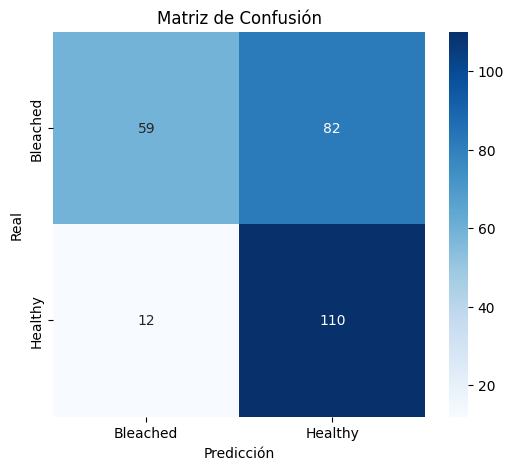

In [ ]:
if X_test.shape[0] > 0:
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()
else:
    print("El conjunto de test está vacío. No se puede evaluar el modelo.")